In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import json
import random
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
# from transformers import *
from tqdm import tqdm
# from sklearn.model_selection import StratifiedKFold
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
# from transformers import BertTokenizer
# from transformers import BertForSequenceClassification, AdamW, BertConfig
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *
from sklearn.utils import *
import pandas as pd
import string

In [4]:
d1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
d1_test= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
d1

,text,key,ta_a1,ta_a2,ta_a3,ta_a4,ta_a5,ta_a6
0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,question_1,NaN,NaN,0.0,0.0,0.0,0.0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,question_1,NaN,NaN,NaN,0.0,NaN,NaN
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,question_1,NaN,NaN,NaN,NaN,0.0,NaN
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆,question_1,NaN,NaN,NaN,NaN,1.0,NaN
4,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...,question_1,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6774,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭,question_1,NaN,NaN,1.0,NaN,NaN,NaN
6775,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6776,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...,question_1,NaN,0.0,NaN,NaN,NaN,NaN
6777,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...,question_1,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
def normalize_text(text):
  # emoji_pattern = re.compile("["
  #                             u"\U0001F600-\U0001F64F"  # emoticons
  #                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  #                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
  #                             u"\U0001F700-\U0001F77F"  # alchemical symbols
  #                             u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
  #                             u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
  #                             u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
  #                             u"\U0001FA00-\U0001FA6F"  # Chess Symbols
  #                             u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
  #                             u"\U00002702-\U000027B0"  # Dingbats
  #                             u"\U000024C2-\U0001F251"
  #                             "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji.demojize(text)
  text = text.replace("ðŸ¤§", " ")
  text = text.replace("&amp;", " ")
  text = text.replace("\n", " ")
  text = text.replace("ðŸ˜¡", " ")
  # text = emoji_pattern.sub(r'', text)
  return text

d1['text'] = d1['text'].apply(lambda x: normalize_text(x))
d1_test['text'] = d1_test['text'].apply(lambda x: normalize_text(x))

In [6]:
d1

,text,key,ta_a1,ta_a2,ta_a3,ta_a4,ta_a5,ta_a6
0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...,question_1,NaN,NaN,0.0,0.0,0.0,0.0
1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...,question_1,NaN,NaN,NaN,0.0,NaN,NaN
2,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா,question_1,NaN,NaN,NaN,NaN,0.0,NaN
3,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்...,question_1,NaN,NaN,NaN,NaN,1.0,NaN
4,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...,question_1,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
6774,:loudly_crying_face::loudly_crying_face::loudl...,question_1,NaN,NaN,1.0,NaN,NaN,NaN
6775,:face_with_rolling_eyes::face_with_rolling_eye...,question_1,NaN,NaN,NaN,NaN,0.0,NaN
6776,:police_car_light:எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ...,question_1,NaN,0.0,NaN,NaN,NaN,NaN
6777,:rolling_on_the_floor_laughing: :rolling_on_th...,question_1,NaN,0.0,NaN,NaN,NaN,NaN


In [7]:
X1 = list(d1['text'])
X1_test = list(d1_test['text'])

col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')
    d1_test[col] = pd.to_numeric(d1_test[col], errors='coerce')


d1['label'] = d1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
d1_test['label'] = d1_test[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values


d1 = d1.drop(col_lst, axis=1)
d1_test = d1_test.drop(col_lst, axis=1)


d1['label'] = d1['label'].astype(int)
d1_test['label'] = d1_test['label'].astype(int)


d1 = d1[['label', 'text']]
d1_test = d1_test[['label', 'text']]
d1_test

,label,text
0,0,வைரமுத்து ஒரு காம மிருகம் என்பது சினிமா துற...
1,1,valimai ajithkumar ஏண்டா குள்ள புண்டைக...
2,0,ambedkarblueshirtrally இந்த போராட்டத்துக்கு ...
3,0,breaking திருச்சி மாவட்டம் மணப்பாறையை அடுத...
4,1,bachelor :face_with_steam_from_nose::face_wit...
...,...,...
1130,1,:face_with_tears_of_joy::face_with_tears_of_jo...
1131,1,:grinning_face_with_smiling_eyes: தமிழ் தெரிஞ்...
1132,1,:grinning_face_with_sweat::grinning_face_with_...
1133,1,:grinning_cat::pencil: — ஆமாம் வேச ஆமாம் வேச அ...


In [8]:
y_data1 = d1["label"]
y1 = y_data1.values

print(y1)
print(len(y1))

[0 0 0 ... 0 0 1]
6779


In [9]:
# def getPerformanceOfLoader(test_dataloader):
#     model.eval()
#     # Tracking variables
#     predictions , true_labels = [], []
#     # Predict
#     for batch in test_dataloader:
#     #print(batch)
#     # Add batch to GPU
#         batch = tuple(t.to(device) for t in batch)

#         # Unpack the inputs from our dataloader
#         b_input_ids, b_input_mask, b_labels = batch

#         # Telling the model not to compute or store gradients, saving memory and
#         # speeding up prediction
#         with torch.no_grad():
#             # Forward pass, calculate logit predictions
#             outputs = model(b_input_ids, token_type_ids=None,
#                       attention_mask=b_input_mask)

#         logits = outputs[0]

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()
#         # Store predictions and true labels
#         pred_flat = np.argmax(logits, axis=1).flatten()
#         predictions.extend(pred_flat)
#         true_labels.extend(label_ids)

#     df = pd.DataFrame()
#     df['id']=testData['text']
#     df['target'] = predictions

#     return df

In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
model_name = "Hate-speech-CNERG/indic-abusive-allInOne-MuRIL"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

def get_predictions(df):
    y_true = df['label'].tolist()
    y_pred = []

    for text in tqdm(df['text'], desc="Predicting"):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            y_pred.append(pred)

    return y_true, y_pred

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/525 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/950M [00:00<?, ?B/s]

In [11]:
def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c,
            'precision': precisionScore, 'recall': recallScore}



In [12]:
# d1_subset = d1.head(200)
y_true, y_pred = get_predictions(d1_test)

# Evaluate
metrics = evalMetric(y_true, y_pred)
print("Evaluation Metrics:\n", metrics)

Predicting: 100%|██████████| 1135/1135 [04:08<00:00,  4.56it/s]

Evaluation Metrics:
 {'accuracy': 0.7832599118942731, 'mF1Score': 0.7554085022285763, 'f1Score': 0.8379446640316206, 'auc': np.float64(0.746609647095084), 'precision': 0.7979924717691342, 'recall': 0.8821081830790569}


In [15]:
# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, labels=["Not Hate", "Hate"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

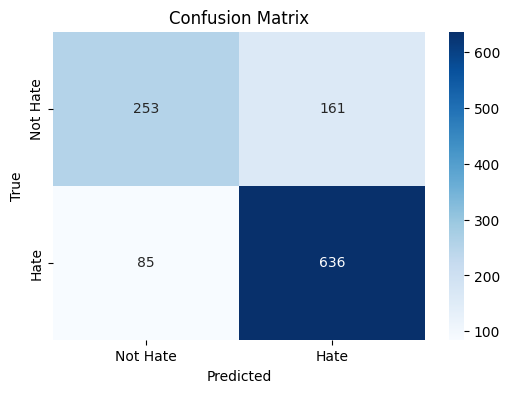

In [16]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)